In [2]:
import numpy as np
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
from sklearn import linear_model
import time

In [6]:
def reach_keypoints_heuristic(point_cloud,
                             n_clusters=8):
    p = np.squeeze(point_cloud)
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=0).fit(p)
    centers = kmeans.cluster_centers_
    hull = ConvexHull(centers[:, :2])
    hull = centers[hull.vertices]
    grasp_point = random.choice(centers).reshape([1, 3])
    invalid = np.amin(np.linalg.norm(
              grasp_point - hull, axis=1)) == 0
    while invalid:
        grasp_point = random.choice(centers).reshape([1, 3])
        invalid = np.amin(np.linalg.norm(
                  grasp_point - hull, axis=1)) == 0
    
    xs, ys, zs = np.split(centers, [1, 2], axis=1)
    ransac = linear_model.RANSACRegressor()
    ransac.fit(xs, np.squeeze(ys))
    centers_inlier = centers[ransac.inlier_mask_]
    if np.random.uniform() > 0.5:
        inlier_mask = np.logical_not(ransac.inlier_mask_)
        if np.sum(inlier_mask) > 1:
            ransac = linear_model.RANSACRegressor()
            ransac.fit(xs[inlier_mask], np.squeeze(ys[inlier_mask]))
            centers_inlier = centers[inlier_mask]
            centers_inlier = centers_inlier[ransac.inlier_mask_]
        
    k = np.squeeze(ransac.estimator_.coef_)
    func_vect = np.reshape(
        [1/np.sqrt(1+np.square(k)),
         k/np.sqrt(1+np.square(k)), 0], [1, 3])
    proj = np.sum(func_vect * (
        centers_inlier - np.mean(centers_inlier, 
                                 axis=0, keepdims=True)), axis=1)
    indices = [np.argmax(proj), np.argmin(proj)]
    sides = centers_inlier[indices]
    dist = [None, None]
    for iside in [0, 1]:
        dist[iside] = np.linalg.norm(sides[iside] - centers, axis=1)
        dist[iside] = np.sum(np.square(
            dist[iside][np.argsort(dist[iside])[n_clusters//2]]))
    sides = sides if dist[0] > dist[1] else sides[[1, 0]]
    func_point = sides[0]
    approx_vect = sides[0] - sides[1]
    func_vect = func_vect if func_vect.dot(
        approx_vect) > 0 else -func_vect
    
    if True:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111)
        ax.scatter(p[:, 0], p[:, 1], c='green', s=0.1, alpha=0.3)
        ax.scatter(
            centers_inlier[:, 0], centers_inlier[:, 1], c='orange', s=10)
        ax.scatter(
            func_point[0], func_point[1], c='green', s=10)
        ax.scatter(
            [func_point[0] + func_vect[0, 0] * 0.1], [func_point[1] + func_vect[0, 1] * 0.1], c='green', s=10)
        ax.scatter(
            grasp_point[0, 0], grasp_point[0, 1], c='red', s=10)
        plt.xlim((0.4, 1.0))
        plt.ylim((-0.5, 0.1))
        plt.show()


In [7]:
point_cloud = np.load(open('../../episodes/grasp_4dof_random_single/point_cloud/000000.npy', 'rb'))

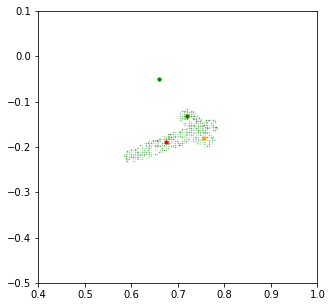

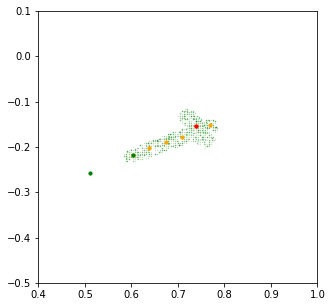

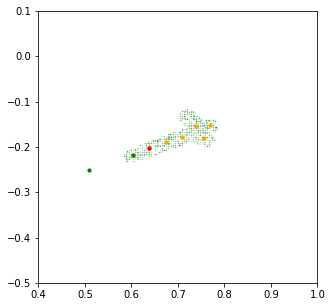

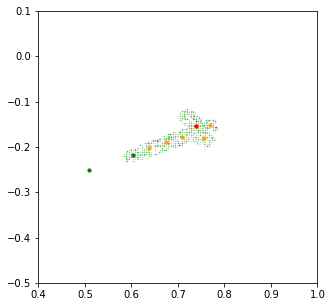

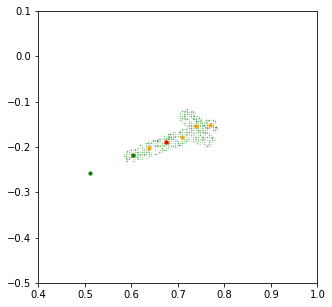

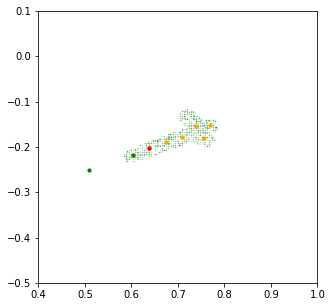

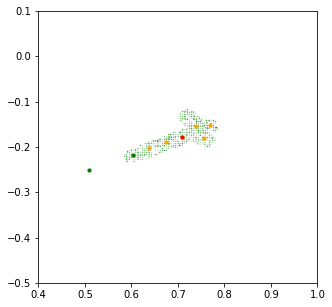

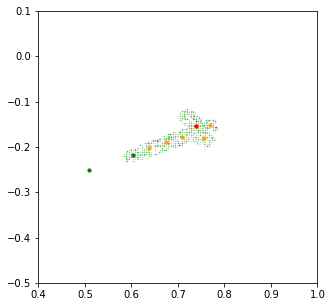

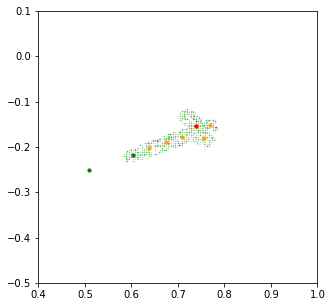

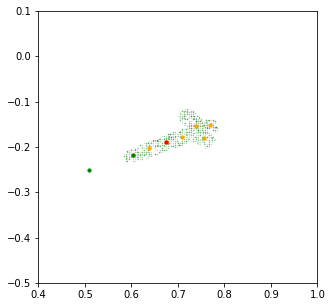

0.21753463745117188


In [8]:
start = time.time()
for _ in range(10):
    poke_keypoints_heuristic(point_cloud)
    
end = time.time()
print((end-start)/10)